In [1]:
#импорт библиотек
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные моделиё
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #сплитование выборки

%matplotlib inline
plt.style.use('seaborn')

<ipython-input-1-3cdb0073e4bf>:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [3]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.3/212.3 KB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 2.1 MB/s eta 0:00:00


In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
import hyperopt
from hyperopt import hp, fmin, tpe, Trials
import optuna
from pandas._config import options

In [5]:
# подключаем google диск, где у нас хранятся данные
from google.colab import drive
drive.mount('/content/drive')
 # берем необходимый нам файл с диска, указав путь
data = pd.read_csv('./drive/MyDrive/SF_data/_train_sem09 (1).csv')
data.head()

Mounted at /content/drive


,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


Данные представлены в формате CSV.  Каждая строка представляет молекулу. 

*    Первый столбец Activity содержит экспериментальные данные, описывающие фактический биологический ответ [0, 1]; 
*    Остальные столбцы D1-D1776 представляют собой молекулярные дескрипторы — это вычисляемые свойства, которые могут фиксировать некоторые характеристики молекулы, например размер, форму или состав элементов.


<Axes: xlabel='Activity', ylabel='count'>

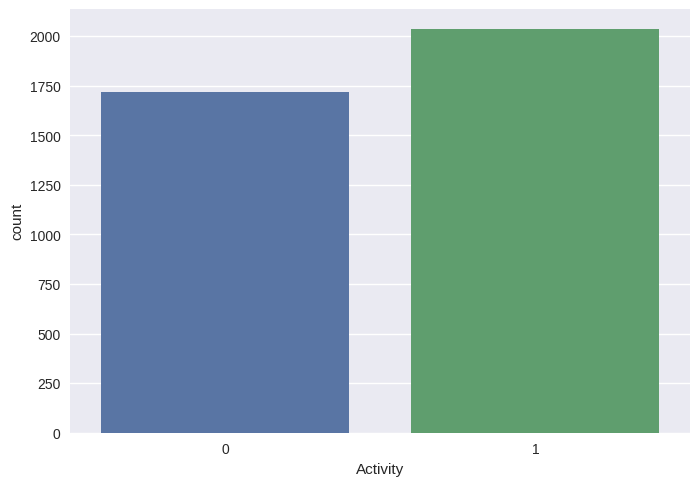

In [6]:
# Смотрим на сбалансированность классов:
sns.countplot(data=data, x='Activity')

In [7]:
# Создаем матрицу наблюдений X и вектор ответов y:
X = data.drop(['Activity'], axis=1)
y = data['Activity']

In [8]:
# Разделяем выборку на тренировочную и тестовую в соотношении 80/20:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.2)

## Логистическая регрессия


In [9]:
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(max_iter = 1000, random_state=42)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train, y_train)
print("accuracy на тестовом наборе: {:.3f}".format(log_reg.score(X_test, y_test)))
y_test_pred = log_reg.predict(X_test)
print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.754
f1_score на тестовом наборе: 0.777


### Базовые методы

#### GridSearchCV

In [11]:
param_grid = {'penalty': ['l2', 'l1', 'none'] ,#тип регурялизации
              'solver': ['lbfgs', 'saga', 'liblinear'], #алгоритм оптимизации
              }
grid_search = GridSearchCV(
    estimator=linear_model.LogisticRegression(
        random_state=42, #генератор случайных чисел
        max_iter=50 #количество итераций на сходимость
    ), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search.fit(X_train, y_train) 
print("accuracy на тестовом наборе: {:.3f}".format(grid_search.score(X_test, y_test)))
y_test_pred = grid_search.predict(X_test)
print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
10 fits failed out of a total of 45.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solver lbf

CPU times: user 1.69 s, sys: 98.4 ms, total: 1.79 s
Wall time: 1min 10s
accuracy на тестовом наборе: 0.750
f1_score на тестовом наборе: 0.772
Наилучшие значения гиперпараметров: {'penalty': 'l1', 'solver': 'liblinear'}


In [16]:
param_grid = [
              {'penalty': ['l2', 'none'] , # тип регуляризации
              'solver': ['lbfgs', 'sag'], # алгоритм оптимизации
               'C': list(np.linspace(0.01, 1, 10, dtype=float))}, # уровень силы регурялизации
              
              {'penalty': ['l1', 'l2'] ,
              'solver': ['liblinear', 'saga'],
               'C': list(np.linspace(0.01, 1, 10, dtype=float))}
]
grid_search_1 = GridSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=50), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search_1.fit(X_train, y_train) 
print("accuracy на тестовом наборе: {:.3f}".format(grid_search_1.score(X_test, y_test)))
y_test_pred = grid_search_1.predict(X_test)
print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_1.best_params_))

CPU times: user 9.52 s, sys: 591 ms, total: 10.1 s
Wall time: 12min 2s
accuracy на тестовом наборе: 0.754
f1_score на тестовом наборе: 0.783
Наилучшие значения гиперпараметров: {'C': 0.34, 'penalty': 'l1', 'solver': 'saga'}


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [17]:
result_cv = pd.DataFrame(grid_search_1.cv_results_)
result_cv.shape


(80, 16)

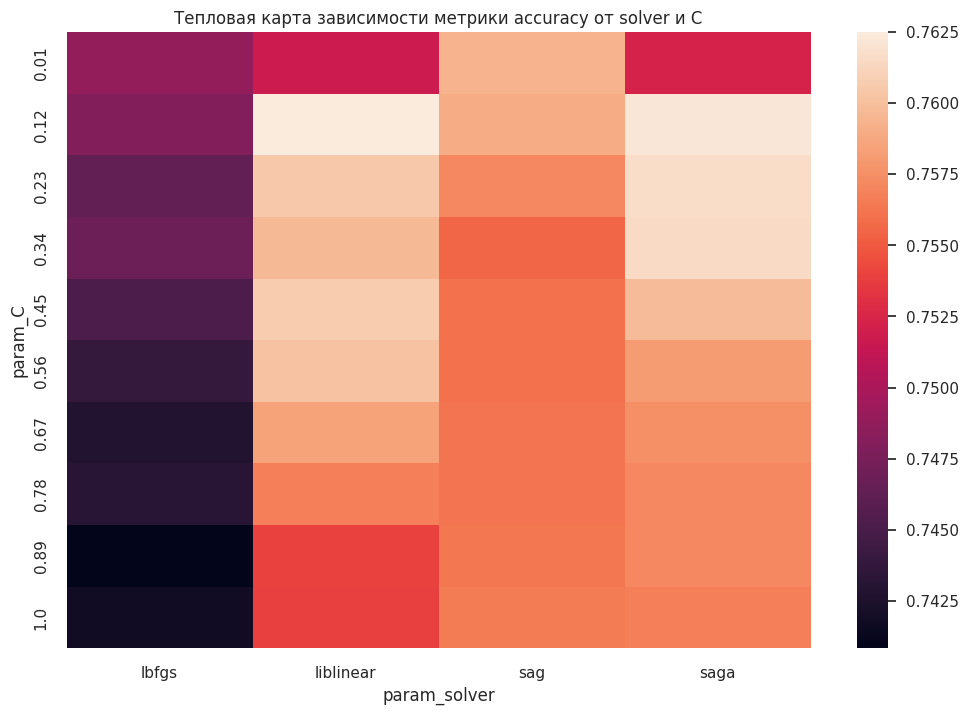

In [18]:
# отрисуем, как менялась точность при различных гиперпараметрах
visual = pd.pivot_table(pd.DataFrame(grid_search_1.cv_results_),
                        values='mean_test_score', index='param_C',
                        columns='param_solver')
sns.heatmap(visual)
plt.title('Тепловая карта зависимости метрики accuracy от solver и С') # подпись графика
sns.set(rc={'figure.figsize':(12, 8)}) #задаем размер графика

#### RandomizedSearchCV

In [15]:
#np.linspace(start(от), stop(до), num=50(количество),dtype- тип данных)
param_distributions = {'penalty': ['l1', 'none'] ,
              'solver': ['liblinear', 'saga'],
               'C': list(np.linspace(0.01, 1, 10, dtype=float))},
            
random_search = RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42), 
    param_distributions=param_distributions, 
    cv=5, 
    n_iter = 50, 
    n_jobs = -1
)  
%time random_search.fit(X_train, y_train) 
print("accuracy на тестовом наборе: {:.3f}".format(random_search.score(X_test, y_test)))
y_test_pred = random_search.predict(X_test)
print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search.best_params_))

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 40 is smaller than n_iter=50. Running 40 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
50 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py",

CPU times: user 13.6 s, sys: 512 ms, total: 14.2 s
Wall time: 11min 53s
accuracy на тестовом наборе: 0.758
f1_score на тестовом наборе: 0.784
Наилучшие значения гиперпараметров: {'solver': 'saga', 'penalty': 'l1', 'C': 0.34}


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Таким образом, поиск гиперпараметров улучшил результат метрики, но не намного. Однако оба метода (GridSearchCV и RandomizedSearchCV) отобрали одинаковые параметры, время, затраченное на поиск параметров обоими методами практически равнозначно. 

Теперь попробуем найти параметры с помощью метода продвинутой оптимизации Hyperopt.


### Продвинутая оптимизация: Hyperopt

In [22]:
# зададим пространство поиска гиперпараметров
list_penalty=['l1', 'l2']
list_solver=['liblinear', 'saga']
space={'penalty': hp.choice(label='penalty', options=list_penalty),
        'solver': hp.choice(label='solver', options=list_solver),
            'C': hp.choice(label='C', options=list(np.linspace(0.01, 1, 10, dtype=float)))
      }

In [23]:
# зафксируем random_state
random_state = 42
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'penalty': str(params['penalty']),
              'solver': str(params['solver']),
              'C': float(params['C'])}
    
  
    # используем эту комбинацию для построения модели
    model = linear_model.LogisticRegression(**params, random_state=random_state)

    # применим  cross validation с тем же количеством фолдов
    score = cross_val_score(model, X_train, y_train, cv=5, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [24]:
# начинаем подбор гиперпараметров
%%time

trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=20, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результатаnp.random.RandomState
         )
print("Наилучшие значения гиперпараметров {}".format(best))

100%|██████████| 20/20 [06:19<00:00, 18.96s/trial, best loss: -0.7901009826064027]
Наилучшие значения гиперпараметров {'C': 3, 'penalty': 0, 'solver': 1}
CPU times: user 2.96 s, sys: 793 ms, total: 3.75 s
Wall time: 6min 19s


In [28]:
print(list(np.linspace(0.01, 1, 10, dtype=float))[3])
print(list_penalty[0])
print(list_solver[1])

0.34
l1
saga


In [27]:
# рассчитаем точность для тестовой выборки
model = linear_model.LogisticRegression(  
    random_state=42,
    penalty=list_penalty[0],
    solver=list_solver[1],
    C=list(np.linspace(0.01, 1, 10, dtype=float))[3]
)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)

print("accuracy на тестовом наборе: {:.3f}".format(model.score(X_test, y_test)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.758
f1_score на тестовом наборе: 0.784


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Hyperopt отобрал те же параметры для логистической регрессии, что и другие методы поиска гиперпараметров, но время, затраченное на поиск, сократилось почти в два раза.

Теперь применим к нашим данным модель Случайный лес.

## Случайный лес

In [32]:
#Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(random_state=42)

#Обучаем модель
rf.fit(X_train, y_train)
#Выводим значения метрики 
y_train_pred = rf.predict(X_train)
print('accuracy на тестовом наборе: {:.3f}'.format(random_search_forest.score(X_test, y_test)))
y_test_pred = rf.predict(X_test)
print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.788
f1_score на тестовом наборе: 0.805


### Базовые методы: RandomizedSearchCV

Для экономии времени используем для поиска гиперпараметров только RandomizedSearchCV, т.к. этот метод был немного экономичнее по времени.

In [31]:
param_distributions = {'n_estimators': list(range(100, 200, 10)),
              'min_samples_leaf': [1,2,3,4,5,6,7],
              'max_depth': list(np.linspace(20, 50, 2, dtype=int))
              }
            
random_search_forest = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_distributions=param_distributions, 
    cv=5,
    n_iter = 50, 
    n_jobs = -1
)  
%time random_search_forest.fit(X_train, y_train) 
y_train_pred = random_search_forest.predict(X_train)

print("accuracy на тестовом наборе: {:.3f}".format(random_search_forest.score(X_test, y_test)))
y_test_pred = random_search_forest.predict(X_test)
print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_forest.best_params_))

CPU times: user 5.77 s, sys: 390 ms, total: 6.16 s
Wall time: 7min 40s
accuracy на тестовом наборе: 0.788
f1_score на тестовом наборе: 0.809
Наилучшие значения гиперпараметров: {'n_estimators': 130, 'min_samples_leaf': 1, 'max_depth': 20}


### Продвинутая оптимизация.

### Hyperopt

In [33]:
# зададим пространство поиска гиперпараметров
space={'n_estimators': hp.quniform('n_estimators', 100, 200, 1),
       'max_depth' : hp.quniform('max_depth',15, 35, 1),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 10, 1)
      }


In [34]:
# зафксируем random_state
random_state = 42
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'min_samples_leaf': int(params['min_samples_leaf'])
              }
  
    # используем эту комбинацию для построения модели
    model = ensemble.RandomForestClassifier(**params, random_state=random_state)

    # обучаем модель
    model.fit(X, y)
    score = metrics.f1_score(y, model.predict(X))
    
    # обучать модель можно также с помощью кросс-валидации
    # применим  cross validation с тем же количеством фолдов
    # score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [35]:
# начинаем подбор гиперпараметров
%%time

trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=50, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результатаnp.random.RandomState
         )
print("Наилучшие значения гиперпараметров {}".format(best))

100%|██████████| 50/50 [02:34<00:00,  3.10s/trial, best loss: -1.0]
Наилучшие значения гиперпараметров {'max_depth': 21.0, 'min_samples_leaf': 1.0, 'n_estimators': 158.0}
CPU times: user 2min 32s, sys: 1.12 s, total: 2min 33s
Wall time: 2min 34s


In [53]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(
    random_state=random_state, 
    n_estimators=158,
    max_depth=21, #int(best['max_depth']),
    min_samples_leaf=1 #int(best['min_samples_leaf'])
)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print('f1_score на обучающем наборе: {:.3f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.3f}".format(model.score(X_test, y_test)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 1.000
accuracy на тестовом наборе: 0.791
f1_score на тестовом наборе: 0.810


### Optuna

In [41]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 10)
  max_depth = trial.suggest_int('max_depth', 15, 35, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  # обучаем модель
  model.fit(X_train, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train))

  return score

In [42]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=50)

[I 2023-04-06 03:57:19,721] A new study created in memory with name: RandomForestClassifier
[I 2023-04-06 03:57:22,334] Trial 0 finished with value: 0.8982072318444242 and parameters: {'n_estimators': 140, 'max_depth': 33, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.8982072318444242.
[I 2023-04-06 03:57:25,835] Trial 1 finished with value: 0.9886607416487896 and parameters: {'n_estimators': 180, 'max_depth': 18, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.9886607416487896.
[I 2023-04-06 03:57:29,722] Trial 2 finished with value: 0.9087022900763359 and parameters: {'n_estimators': 200, 'max_depth': 16, 'min_samples_leaf': 8}. Best is trial 1 with value: 0.9886607416487896.
[I 2023-04-06 03:57:32,227] Trial 3 finished with value: 0.8982072318444242 and parameters: {'n_estimators': 140, 'max_depth': 25, 'min_samples_leaf': 10}. Best is trial 1 with value: 0.9886607416487896.
[I 2023-04-06 03:57:33,868] Trial 4 finished with value: 0.8938750758035171 and parameters: {'

CPU times: user 2min 47s, sys: 1.3 s, total: 2min 49s
Wall time: 2min 51s


In [43]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 160, 'max_depth': 22, 'min_samples_leaf': 1}
f1_score на обучающем наборе: 1.00


In [44]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state, )
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print("accuracy на тестовом наборе: {:.3f}".format(model.score(X_test, y_test)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.790
f1_score на тестовом наборе: 0.810


Используем кросс-валидацию при поиске с помощью Optuna:

In [49]:
def optuna_rf_cross(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 10)
  max_depth = trial.suggest_int('max_depth', 15, 35, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  
  # обучаем модель
  score = cross_val_score(model, X_train, y_train, cv=5, scoring="f1", n_jobs=-1).mean()
  #model.fit(X_train, y_train)
  #score = metrics.f1_score(y_train, model.predict(X_train))

  return score

In [50]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf_cross, n_trials=20)

[I 2023-04-06 04:14:02,642] A new study created in memory with name: RandomForestClassifier
[I 2023-04-06 04:14:08,294] Trial 0 finished with value: 0.8144254419965874 and parameters: {'n_estimators': 100, 'max_depth': 16, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.8144254419965874.
[I 2023-04-06 04:14:18,817] Trial 1 finished with value: 0.8116357854375058 and parameters: {'n_estimators': 170, 'max_depth': 23, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.8144254419965874.
[I 2023-04-06 04:14:29,081] Trial 2 finished with value: 0.8137604253109323 and parameters: {'n_estimators': 160, 'max_depth': 16, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.8144254419965874.
[I 2023-04-06 04:14:34,787] Trial 3 finished with value: 0.8045474352977775 and parameters: {'n_estimators': 120, 'max_depth': 15, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.8144254419965874.
[I 2023-04-06 04:14:45,025] Trial 4 finished with value: 0.8144722739603836 and parameters: {'n_

CPU times: user 2 s, sys: 592 ms, total: 2.59 s
Wall time: 3min 29s


In [51]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 200, 'max_depth': 26, 'min_samples_leaf': 1}
f1_score на обучающем наборе: 0.82


In [52]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state, )
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print("accuracy на тестовом наборе: {:.3f}".format(model.score(X_test, y_test)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.788
f1_score на тестовом наборе: 0.809


Таким образом, модель Случайный лес в целом показала лучшие результаты по сравнению с Логистической регрессией. 

Поиск гиперпараметров с использованием продвинутых методов существенно экономичнее по времени, чем с помощью базовых методов.

Поиска гиперпараметров разными способами дал практически одинаковые результаты. Для логистической регрессии они полностью совпали. Для случайного леса совпали частично.

